In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def dydx(x,y):
 
    y_derivs = np.zeros(2)
    
    y_derivs[0] = y[1]
    
    y_derivs[1] = -1*y[0]
    
    return y_derivs

In [3]:
def cashk_mv_core(dydx,xi,yi,nv,h):
    
    #declare k arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
    
    y_temp = np.zeros(nv)
    
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs
    
    c2 = 1/5
    a21 = 1/5
    y_temp[:] = yi[:] + a21*k1[:]
    y_derivs = dydx(xi + c2*h,y_temp[:])
    k2[:] = h*y_derivs[:]
    
    c3 = 3/10
    a31 = 3/40
    a32 = 9/40
    y_temp[:] = yi[:] + a31*k1[:] + a32*k2[:]
    y_derivs = dydx(xi+c3*h,y_temp[:])
    k3[:] = h*y_derivs[:]
       
    c4 = 3/5
    a41 = 3/10
    a42 = -9/10
    a43 = 6/5
    y_temp[:] = yi[:] + a41*k1[:] + a42*k2[:] + a43*k3[:]
    y_derivs = dydx(xi + c4*h,y_temp)
    k4[:] = h*y_derivs[:]
    
    c5 = 1
    a51 = -11/54
    a52 = 5/2
    a53 = -70/27
    a54 = 35/27
    y_temp[:] = yi[:] + a51*k1[:] + a52*k2[:] + a53*k3[:] +a54*k4[:]
    y_derivs = dydx(xi + c5*h,y_temp)
    k5[:] = h*y_derivs[:]
    
    c6 = 7/8
    a61 = 1631/55296
    a62 = 175/512
    a63 = 575/13824
    a64 = 44275/110592
    a65 = 253/4096
    y_temp[:] = yi[:] + a61*k1[:] + a62*k2[:] + a63*k3[:] + a64*k4[:] + a65*k5[:]
    y_derivs = dydx(xi + c6*h,y_temp)
    k6[:] = h*y_derivs[:]
       
    b1 =37/378
    b2 = 0
    b3 = 250/621
    b4 =125/594
    b5 = 0
    b6 = 512/1771
    yipo =  yi + b1*k1 + b2*k2 + b3*k3 + b4*k4 + b5*k5 + b6*k6
    
    b1star = 2825/27648
    b2star = 0
    b3star = 18575/48384
    b4star = 13525/55296
    b5star = 277/14336
    b6star = 1/4
    
    yipostar =   yi[:] + b1star*k1[:] + b2star*k2[:] + b3star*k3[:] + b4star*k4[:] + b5star*k5[:] + b6star*k6[:]
    
    Delta = np.fabs(yipo - yipostar)
    

    return yipo,Delta

In [4]:
def cashk_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    imax = 10000
    
    i = 0
    
    h_step = h
    
    y_2,Delta = cashk_mv_core(dydx,x_i,y_i,nv,h_step)

    while(Delta.max()/tol > 1.0):
        
            
        h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
        y_2,Delta = cashk_mv_core(dydx,x_i,y_i,nv,h_step) # recalcculates Delta, with new h value
            

        if(i>imax):
            print("Too many iterations in cashk_mv_ad()")
            raise StopIteration("Ending after i =",i)
            
        i+=1
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    return y_2,h_new,h_step

In [5]:
def cashk_mv(dfdx,a,b,y_a,tol):
    
    xi = a
    yi = y_a.copy()

    h = 1.0e-4 * (b-a)
    
    imax = 10000
    
    i = 0

    nv = len(y_a)
    
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    flag =1 
    
    while(flag):
              
        yi_new, h_new,h_step = cashk_mv_ad(dydx,xi,yi,nv,h,tol)
        
        h = h_new
        
        if(xi+h_step>b):
            
            h = b-xi
            
            yi_new, h_new, h_step = cashk_mv_ad(dydx,xi,yi,nv,h,tol)
            
            flag = 0
        
        
        xi += h_step
        yi[:] = yi_new[:]
        
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        if(i>=imax):
                       
            print("Maximum iterations reached")
            raise StopIteration("Iteration number =",i)
        
        i += 1
        
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i,xi,h_step,b)
        print(s)
        
        if(xi==b):
            flag = 0
    
    return x,y

In [6]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

x,y = cashk_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b=6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b=6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b=6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b=6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b=6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b=6.28318531
i =  10	x = 0.64276986	h = 0.32169909	b=6.28318531
i =  11	x = 0.93739384	h = 0.29462398	b=6.28318531
i =  12	x = 1.20675386	h = 0.26936002	b=6.28318531
i =  13	x = 1.49426997	h = 0.28751611	b=6.28318531
i =  14	x = 1.76344767	h = 0.26917769	b=6.28318531
i =  15	x = 2.03076151	h = 0.26731385	b=6.28318531
i =  16	x = 2.29758389	h = 0.26682237	b=6.28318531
i =  17	x = 2.56844699	h = 0.27086310	b=6.28318531
i =  18	x = 2.84768738	h = 0.27924039	b=6.28318531
i =  19	x = 3.12869484	h = 0.28100745	b=6.28318531
i =  20	x = 3.39732623	h = 0.26

[]

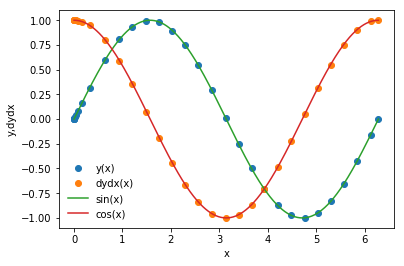

In [7]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o', label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y,dydx')
plt.legend(frameon=False)
plt.plot()

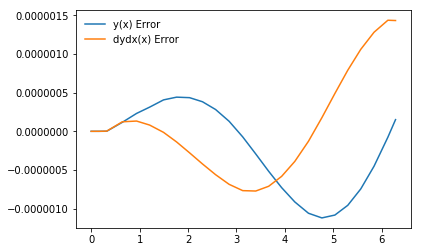

In [8]:
sine = np.sin(x)
cosine = np.cos(x)
y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)
plt.plot(x,y_error, label="y(x) Error")
plt.plot(x,dydx_error, label = "dydx(x) Error")
plt.legend(frameon=False)
plt.show()